In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The **JAX RL Training Workflow**:

1. Run the entire notebook end-to-end and check out the outputs.
    - This will train a policy network on the CartPole environment
    - You'll be able to track training progress using graphs
2. Experiment with different hyperparameters in the `train()` function:
    - Learning rate (currently 1e-3)
    - Gamma discount factor (currently 0.99)
    - Number of episodes (currently 1000)
3. Update the code in the Policy class and training loop:
    - Modify the network architecture
    - Add new metrics to track in wandb
    - Try different optimizers or gradient clipping values
    - Experiment with different action selection strategies
4. The trained model is automatically saved and can be loaded for:
    - Further training
    - Evaluation
    - Deployment in different environments

In [2]:
import jax
import gymnax
from flax import nnx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import collections
from tqdm import tqdm

key = jax.random.key(0)
key, key_reset, key_act, key_step = jax.random.split(key, 4)

env, env_params = gymnax.make("CartPole-v1")

In [3]:
env.action_space(env_params).n
env.observation_space(env_params).shape[0]

4

In [ ]:
class Policy(nnx.Module):
  """A neural network policy for the REINFORCE algorithm.
  
  This policy network maps observations to action probabilities using
  a 3-layer neural network with leaky ReLU activations. It implements
  both forward pass and action selection methods.
  """
  def __init__(self, observation_space, action_space, rngs:nnx.Rngs):
    """Initialize the policy network.
    
    Args:
        observation_space: The environment's observation space object
        action_space: The environment's action space object
        rngs: Random number generator state for initialization
    """
    super().__init__()
    
    # Initialize layers with Xavier normal initialization for better gradient flow
    kernel_init = nnx.initializers.xavier_normal()
    self.layer1 = nnx.Linear(observation_space.shape[0], 128, rngs = rngs, kernel_init=kernel_init)
    self.layer2 = nnx.Linear(128, 128, rngs=rngs, kernel_init=kernel_init)
    self.layer3 = nnx.Linear(128, action_space.n, rngs=rngs, kernel_init=kernel_init)

  def __call__(self, x):
    """Forward pass through the network.
    
    Args:
        x: Input observation tensor
    Returns:
        Logits for action probabilities
    """
    x = jax.nn.leaky_relu(self.layer1(x))
    x = jax.nn.leaky_relu(self.layer2(x))
    return self.layer3(x)

  def select_action(self, x, key):
    """Sample an action from the policy's probability distribution.
    
    Args:
        x: Input observation tensor
        key: JAX random key for sampling
    Returns:
        Selected action index
    """
    logits = self(x)
    return jax.random.categorical(key, logits)
  
@nnx.jit
def loss(model, obs, actions, returns):
    """Compute the REINFORCE policy gradient loss.
    This implements the policy gradient loss: -E[log(π(a|s)) * G_t]
    where π(a|s) is the policy's probability of taking action a in state s,
    G_t is the discounted return from timestep t, and E[] denotes the
    expectation (implemented as a mean over the batch).
    
    Args:
        model: The policy network
        obs: Batch of observations
        actions: Batch of actions taken
        returns: Batch of discounted returns
    Returns:
        Mean policy gradient loss
    """
    log_logits = jax.nn.log_softmax(model(obs))
    # Get log probabilities of the actions that were actually taken
    log_prob_taken = jnp.take_along_axis(log_logits, actions[:, None], axis=1).squeeze()
    # Negative mean for gradient ascent (we want to maximize expected return)
    return -jnp.mean(log_prob_taken * returns)

def compute_returns(rewards, gamma):
    """Compute discounted returns for a sequence of rewards.
    
    Args:
        rewards: List of rewards from an episode
        gamma: Discount factor (0 < gamma <= 1)
    Returns:
        Array of discounted returns for each timestep
    """
    R = 0
    returns = []
    # Compute returns backwards: R[t] = r[t] + gamma * R[t+1]
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return jnp.array(returns)

# Initialize the policy network with the environment's spaces
model = Policy(env.observation_space(env_params), env.action_space(env_params), rngs=nnx.Rngs(0))

In [ ]:
def train(env, env_params, model, episodes: int = 50, learning_rate=1e-3, gamma=0.99):
    """Train the policy using REINFORCE algorithm.
    
    Implements the REINFORCE algorithm to train a policy network through episodic interaction
    with the environment. Uses exponential learning rate decay and gradient clipping for stability.
    
    Args:
        env: The Gymnax environment
        env_params: Environment parameters
        model: The policy network to train
        episodes: Number of training episodes
        learning_rate: Initial learning rate
        gamma: Discount factor for computing returns
    Returns:
        Tuple of (losses, rewards) lists tracking training progress
    """
    # Setup learning rate schedule with exponential decay
    # Decays by factor of 0.8 every 100 optimizer steps (not episodes)
    lr_schedule = optax.exponential_decay(
        init_value=learning_rate,
        transition_steps=100,
        decay_rate=0.8,
        )
    
    # Create optimizer with gradient clipping and Adam
    optimizer = nnx.Optimizer(
        model,
        optax.chain(
            optax.clip_by_global_norm(1.0),  # Prevent exploding gradients
            optax.adam(learning_rate=lr_schedule),
        ),
        wrt=nnx.Param
    )
    
    grad_func = nnx.value_and_grad(loss)
    key = jax.random.PRNGKey(0)
    # Keep track of last 100 episode rewards for running average
    total_rewards = collections.deque(maxlen=100)

    all_losses = []
    all_rewards = []
    with tqdm(range(episodes)) as pbar:
        for i in pbar:
          # Lists to store episode data
          episode_obs = []
          episode_actions = []
          episode_rewards = []

          # Run one episode
          done = False
          key, reset_key = jax.random.split(key)
          obs, state = env.reset(reset_key, env_params)

          while not done:
              # Sample action from policy and step environment
              key, action_key, step_key = jax.random.split(key, 3)
              action = model.select_action(obs, action_key)
              next_obs, state, reward, done, _ = env.step(step_key, state, action, env_params)

              # Store transition data
              episode_obs.append(obs)
              episode_actions.append(action)
              episode_rewards.append(reward)
              obs = next_obs

          # Process episode data for training
          total_rewards.append(sum(episode_rewards))
          returns = compute_returns(episode_rewards, gamma)

          # Convert lists to arrays for JAX operations
          final_obs = jnp.stack(episode_obs)
          final_actions = jnp.array(episode_actions)
          final_returns = jnp.array(returns)

          # Normalize returns (mean=0, std=1) for stable gradient scaling
          # This reduces variance in policy gradient estimates
          final_returns = (final_returns - jnp.mean(final_returns)) / (jnp.std(final_returns) + 1e-8)

          # Compute gradients and update policy
          value, grad = grad_func(model, final_obs, final_actions, final_returns)
          optimizer.update(grad)

          # Track and display progress
          avg_reward = sum(total_rewards) / len(total_rewards)
          all_losses.append(value.item())
          all_rewards.append(avg_reward)

          pbar.set_description(f"Episode: {i}, Loss: {value.item():.4f}, Reward: {avg_reward:.2f}")
          # Early stopping if we solve the environment
          if avg_reward >= 495:
              print("\n")
              print(f"Score of {avg_reward} reached, stopping training")
              break

    return all_losses, all_rewards

In [6]:
losses, rewards = train(env, env_params, model, episodes=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode: 999, Loss: 0.0078, Reward: 490.03: 100%|██████████| 1000/1000 [12:05<00:00,  1.38it/s]


Plot saved as 'training_rewards.png'


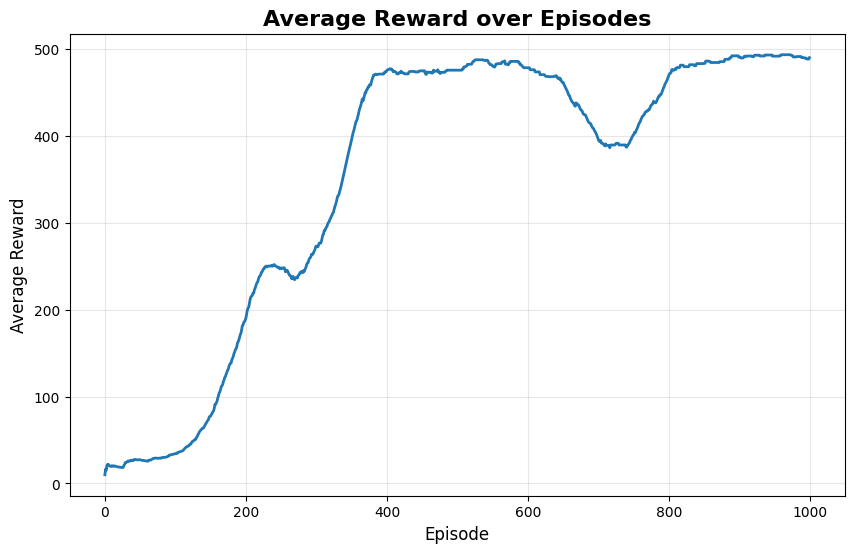

In [ ]:
# Plot only the reward and save it
plt.figure(figsize=(10, 6))

plt.plot(rewards, linewidth=2)
plt.title('Average Reward over Episodes', fontsize=16, fontweight='bold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('training_rewards.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'training_rewards.png'")

plt.show()
plt.close()